**Simulated Annealing for the predator-prey model**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

data = df
print(data)

    Unnamed: 0          t         x         y
0            0   0.000000  4.781635  3.035257
1            1   0.202020  6.114005  2.189746
2            2   0.404040  6.238361  1.478907
3            3   0.606061  5.520524  0.989836
4            4   0.808081  4.582546  0.957827
..         ...        ...       ...       ...
95          95  19.191919  0.310346  1.241890
96          96  19.393939  0.324595  1.437257
97          97  19.595960  0.258083  1.562810
98          98  19.797980  0.283680  1.834171
99          99  20.000000  0.135956  2.147065

[100 rows x 4 columns]


In [7]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

def abs_residual(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T
    t = np.array(data['t'],dtype=float)
    
    y0 = [params[4], params[5]]
    time = np.linspace(t[0],t[-1],len(t))
    model = odeint(lotka_volterra, y0, time, args=(params[0], params[1], params[2], params[3]))
    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t = np.array(data['t'],dtype=float)

    y0 = [params[4], params[5]]
    t = np.linspace(t[0],t[-1],len(t))
    output = odeint(lotka_volterra, y0, t, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = output[i,0]

        y_data = y[i]
        y_model = output[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

In [26]:
def simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data):
    """"
    Performs simulated annealing to find global optimal values.
    init_guess = initial guess (array of real numbers, indicating alpha, beta, delta, gamma, x0 and y0)
    n_iterations = number of iterations to be performed
    std = standard deviation of the normal distribution that determines new possible solutions (step size)
    min_function = objective function (to be minimized)
    T_start = starting temperature for the cooling schedule
    a, b = variables for the cooling schedule
    data = the data to be fitted

    Returns the final solution and the fitness value of that solution
    """

    prev_sol = init_guess
    T = T_start
    
    for n in range(n_iterations):
        # create a new solution
        new_sol = prev_sol + np.random.normal(0, std, size=len(prev_sol))

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < min(np.exp((-min_function(new_sol,data)+min_function(prev_sol,data))/T),1):
            prev_sol = new_sol
        
        # decrease the temperature
        n += 1
        T = a/np.log(n + b)

    return prev_sol, min_function(prev_sol,data)

In [23]:
np.random.seed(4)

init_guess = np.random.uniform(0,1,6)
n_iterations = 1000
std = 0.5
min_function = abs_residual
T_start = 20
a = 3
b = 10
data = df

params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [19]:
print(params, err)

[1.56989663 1.41556504 1.09789456 2.2057903  1.89444561 1.43595026] 557.5898952626274


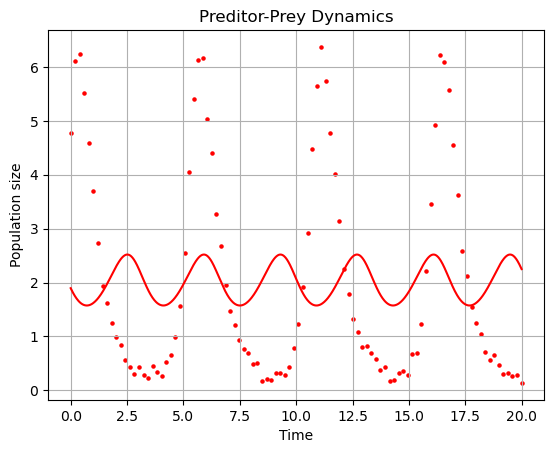

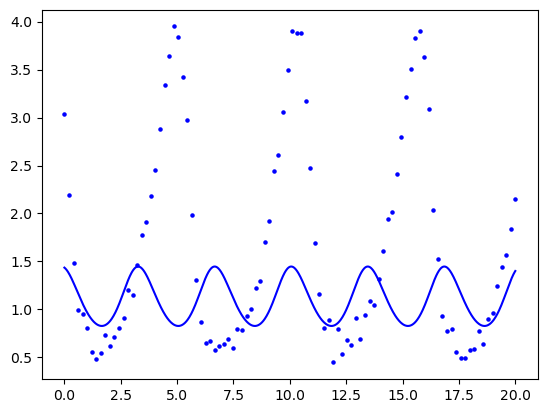

In [20]:
alpha_sim = params[0]
beta_sim = params[1]
delta_sim = params[2]
gamma_sim = params[3]

y0 = [params[4],params[5]]
t = np.linspace(t[0], t[-1], 1000)

output = odeint(lotka_volterra, y0, t, args=(alpha_sim, beta_sim, delta_sim, gamma_sim))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()

**Tuning**

In [39]:
# Parameter tuning for T_start

# init_guess = np.random.uniform(0,1,6)
n_iterations = 1000
std = 0.5
min_function = loss_function_res
# T_start = 20
a = 3
b = 10
data = df

T_range = np.arange(1,20,2)
runs = 0

err_list = []
std_list = []
for T_start in T_range:
    print(T_start)

    err_temp = []
    for _ in range(runs):
        init_guess = np.random.uniform(0,1,6)
        params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)
        err_temp.append(err)

    err_list.append(np.mean(err_temp))
    std_list.append(np.std(err_temp))

1
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1559260721482D+02   r2 =  0.7829790138330D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1559260721482D+02   r2 =  0.7829790138330D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1559260721482D+02   r2 =  0.6482929912039D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1559260721482D+02   r2 =  0.6482929912039D-15
 lsoda--  warning..internal t (=r1

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_77223/1015864847.py:24: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-min_function(new_sol,data)+min_function(prev_sol,data))/T),1):


3
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6878137856369D+01   r2 =  0.4283969910807D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6878137856369D+01   r2 =  0.4283969910807D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6878137856369D+01   r2 =  0.4283969910807D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.6878137856369D+01   r2 =  0.4283969910807D-15
 lsoda--  warning..internal t (=r1

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_77223/1603972001.py:35: RuntimeWarning: overflow encountered in scalar power
  res = (x_data - x_model)**2 + (y_data - y_model)**2


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3642919986171D+01   r2 =  0.2206643339808D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3642919986171D+01   r2 =  0.2206643339808D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3642919986171D+01   r2 =  0.1827062265852D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.3642919986171D+01   r2 =  0.1827062265852D-15
 lsoda--  warning..internal t (=r1) 

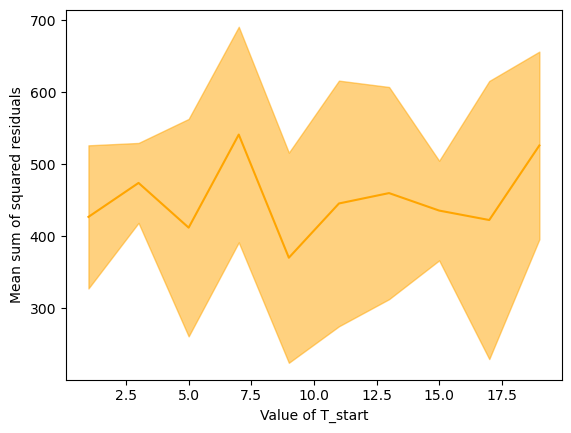

In [40]:
plt.plot(T_range, err_list, color = 'orange')
plt.fill_between(T_range, np.array(err_list)-np.array(std_list), np.array(err_list)+np.array(std_list), color = 'orange', alpha = 0.5)
plt.xlabel('Value of T_start')
plt.ylabel('Mean sum of squared residuals')
plt.show()

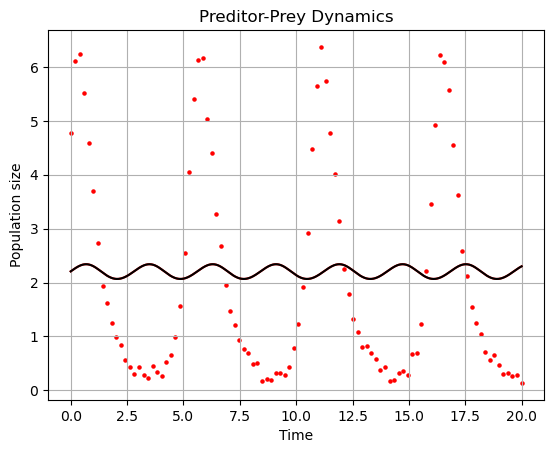

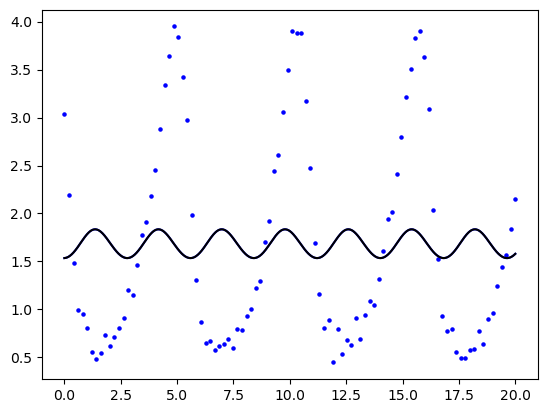

In [24]:
alpha_sim = params[0]
beta_sim = params[1]
delta_sim = params[2]
gamma_sim = params[3]

alpha_sim2 = params2[0]
beta_sim2 = params2[1]
delta_sim2 = params2[2]
gamma_sim2 = params2[3]

y0 = [params[4],params[5]]
y02 = [params2[4],params2[5]]
t = np.linspace(t[0], t[-1], 1000)

output = odeint(lotka_volterra, y0, t, args=(alpha_sim, beta_sim, delta_sim, gamma_sim))
output2 = odeint(lotka_volterra, y02, t, args=(alpha_sim2, beta_sim2, delta_sim2, gamma_sim2))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r", label = 'Residual norm')
plt.plot(t,output2[:,0], color="black", label = 'Residual sum')

plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b", label = 'Residual norm')
plt.plot(t,output2[:,1], color="black", label = 'Residual sum')

plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()

**Stochastic hill climbing**

Chooses at random from uphill moves (steepness determines probability of selection)

In [96]:
def stoch_hill_climb(init_guess, std, min_function, data, n_iterations):
    prev_sol = init_guess

    for _ in range(n_iterations):
        # create a new solution
        new_sol = []
        for param in prev_sol:
            new_param = param + np.random.normal(0,std)
            new_sol.append(new_param)

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
            prev_sol = new_sol

    return prev_sol

In [99]:
init_guess = np.ones(4)
std = 0.1
min_function = abs_residual
data = df
n_iterations = 10000

params_shc = stoch_hill_climb(init_guess,std,min_function,data,n_iterations)

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: overflow encountered in exp
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: invalid value encountered in scalar divide
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):


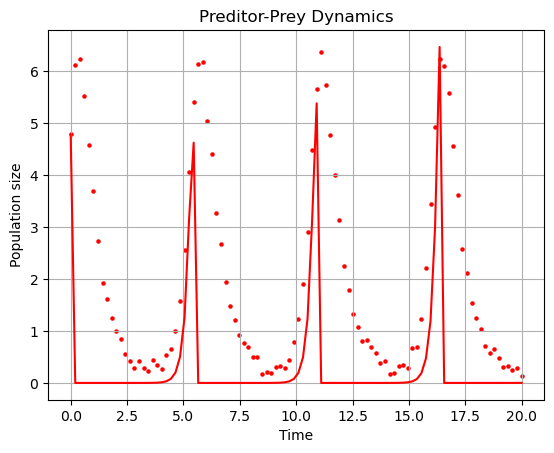

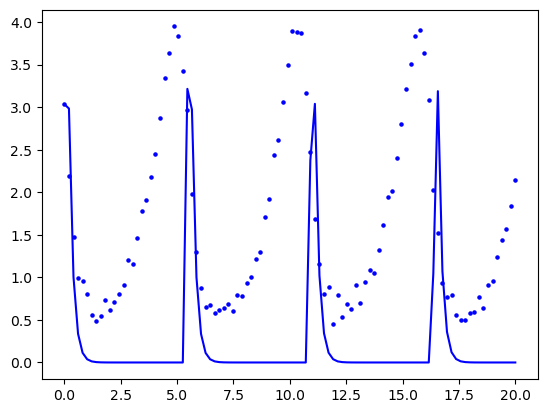

In [100]:
alpha_shc = params_shc[0]
beta_shc = params_shc[1]
delta_shc = params_shc[2]
gamma_shc = params_shc[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output_shc = odeint(lotka_volterra, y0, t, args=(alpha_shc, beta_shc, delta_shc, gamma_shc))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()